In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

import requests
import time
import ast
import random

# Spotipy
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [2]:
# import the dataframes
df_masters = pd.read_csv('Datasets/df_masters.csv')               # albums from the UK and US (until 2000) with >= 20 votes 
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # albums with >= 20 votes, mostly from rock, worldwide
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 

# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_ratings_20.shape}: df_ratings_20')
print(f'{df_masters_blended.shape}: df_masters_blended')

(11346, 13): df_masters
(51222, 5): df_ratings_20
(9667, 13): df_masters_blended


In [3]:
df_masters.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,2190314,3731373,32952558,US,Just Surrender,Phoenix,2010,0.00,13,['Album'],['Rock'],"['Alternative Rock', 'Pop Punk']","Band from Dover Plains, New York, formerly kno..."
1,315009,3624404,1233426,US,Saccharine Trust,"Surviving You, Always",1984,39.70,12,"['LP', 'Album']",['Rock'],"['Punk', 'Avantgarde', 'Experimental']","American rock band from California, formed in ..."
2,983148,3466594,1098693,US,Skycamefalling,10.21,2000,63.65,12,"['Album', 'Enhanced']",['Rock'],"['Metalcore', 'Post-Hardcore']","Metalcore band from Long Island, NY."
3,108050,3347596,11050388,US,Daniel Johnston,Songs of Pain,1983,0.00,21,['Album'],['Rock'],['Lo-Fi'],"Daniel Johnston (born January 22, 1961, Sacram..."
4,492915,3092328,2476600,UK,Skyclad,A Semblance of Normality,2004,47.33,13,['Album'],['Rock'],['Folk Rock'],Skyclad was formed in 1990 by Martin Walkyier ...


# **``album_length``**

In [4]:
df = df_masters
df.shape

(11346, 13)

In [5]:
percentage_album_length_missing = round((df['album_length']==0).sum() / df.shape[0] * 100, 2)

print(f"albums missing album_length: {(df['album_length']==0).sum()} ")
print(f'% missing album_length: {percentage_album_length_missing}%')

albums missing album_length: 2201 
% missing album_length: 19.4%


In [6]:
df_length_0 = df[df['album_length']==0].sort_values(['artist', 'year', 'title'])
df_length_0.shape

(2201, 13)

In [162]:
df_length_0.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
5898,80393,23101,1262360,US,...And You Will Know Us by the Trail of Dead,Madonna,1999,0.0,13,"['LP', 'Album']",['Rock'],"['Art Rock', 'Indie Rock']","American alternative rock band from Austin, Te..."
1683,371750,185850,2602287,US,108,Songs of Separation,1994,0.0,15,['Album'],['Rock'],"['Hardcore', 'Religious']","Metallic hardcore band from New York City, USA..."
11125,371750,326966,1117204,US,108,A New Beat From A Dead Heart,2007,0.0,13,"['LP', 'Album']",['Rock'],['Hardcore'],"Metallic hardcore band from New York City, USA..."
5856,39775,23978,5540610,UK,10cc,10cc,1973,0.0,10,"['LP', 'Album', 'Stereo']",['Rock'],['Art Rock'],"Major 70s UK (founded in Stockport, Greater Ma..."
5416,39775,30571,5540194,UK,10cc,Sheet Music,1974,0.0,10,"['LP', 'Album', 'Stereo']",['Rock'],['Art Rock'],"Major 70s UK (founded in Stockport, Greater Ma..."


**Albums with ``album_length = 0`` that I've gotten with Spotipy**

In [153]:
df_lengths_missing_concat = pd.read_csv('Datasets/df_lengths_missing_concat.csv')
df_lengths_missing_concat.shape

(2558, 5)

In [161]:
df_lengths_missing_concat.head()

,artist,title,name,album_length,tracks
0,...And You Will Know Us by the Trail of Dead,Madonna,madonna,45.57,13
1,108,A New Beat From A Dead Heart,a new beat from a dead heart,34.65,13
2,108,Songs of Separation,songs of separation,32.85,14
3,10cc,10cc,10cc,35.23,10
4,10cc,Deceptive Bends,deceptive bends,51.21,12


**Albums that still have ``album_length = 0`` and I haven't gotten with Spotipy**

In [167]:
df_length_to_do = df_length_0[~df_length_0['title'].isin(df_lengths_missing_concat['title'].values)]
df_length_to_do.reset_index(drop=True, inplace=True)
df_length_to_do.shape

(408, 13)

In [169]:
df_length_to_do.head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,317719,107693,1611310,US,16,Bridges to Burn,2009,0.0,12,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Hardcore', 'Downtempo', 'Southern Rock']","American sludge metal band from San Diego, Cal..."
1,513958,0,4834521,US,3,Summercamp Nightmare,2003,0.0,12,['Album'],['Rock'],"['Prog Rock', 'Heavy Metal']",American progressive rock/metal band from Wood...
2,513958,429178,9441550,US,3,Wake Pig,2004,0.0,11,['Album'],['Rock'],"['Alternative Rock', 'Hard Rock', 'Heavy Metal']",American progressive rock/metal band from Wood...
3,513958,429183,3436139,US,3,The End is Begun,2007,0.0,13,['Album'],['Rock'],['Heavy Metal'],American progressive rock/metal band from Wood...
4,11203,30962,1453338,UK,A Certain Ratio,The Graveyard and The Ballroom,1980,0.0,16,['Album'],"['Electronic', 'Rock']","['Leftfield', 'New Wave']",British post punk & indie funk band formed in ...


In [170]:
df_length_to_do.to_csv('Datasets/df_length_to_do.csv', index=False)

## **``Spotipy`` (Spotify API)**

In [3]:
load_dotenv()

True

In [4]:
user = os.getenv('client_id')
password = os.getenv('client_secret')

# Initialize Spotipy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = user,
                                                           client_secret = password), requests_timeout=10)

### Testing

In [24]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

In [22]:
artist = '108'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

# theorically the artist should be the first result
artist_name = results['artists']['items'][0]['name']
artist_id = results['artists']['items'][0]['id'] # get the artist_id

if artist_name.lower() == artist.lower():
    print(f"artist found: {artist_name} with id '{artist_id}'")
else:
    print(f"Cannot find '{artist}', try some other one")

artist found: 108 with id '3j2S24uHONLPeKvYjG14oH'


In [26]:
albums = get_all_albums(artist_id)

In [27]:
for i in albums:
    print(i['name'])

18.61
A New Beat from a Dead Heart
Creation. Sustenance. Destruction.
Songs Of Separation
Violent World: A Tribute To The Misfits


In [28]:
artist = '108'
title = 'A New Beat From A Dead Heart'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

artists = results['artists']['items']
artists_ids = results['artists']['items'] # get the artist_id

for i in range(len(artists)):
    # artist = artists[i]['name']
    try:
        # look for my artist
        if artist.lower().replace('and', '&') == artists[i]['name'].lower():
            # if it finds my artist:
            artist_id = artists_ids[i]['id']
            print('artist found')
            print(artist)

            artist_albums = get_all_albums(artist_id)

            for album in artist_albums:

                print(album['name'])

                # look for my album
                if album['name'].lower().replace('and', '&') == (title.lower().replace('and', '&')):
                    print('album found')
                    album_id = album['id']
                    results = sp.album(album_id)
                    tracks = results['tracks']['items']
                    song_durations = [song['duration_ms']/60000 for song in tracks]
                    
                    album_length = round(sum(song_durations), 2)

                    break   # once it finds the album, stop
    except:
        print('error')            

artist found
108
18.61
A New Beat from a Dead Heart
album found
artist found
108
Mission Infinite
artist found
108
05s identity
Metta Muzik, Vol. 2
Flex skill
RE:BORN
OVER THE BORDER
kitanoshiro (feat. 108)
Empty Heart (feat. ZiiFlex a.k.a ZIMA) [Remix]


In [29]:
album_length

34.65

Here we can see that the album is found, though not on the exact same name, it doesn't do an exact match because there are other parts in the title, such as **'Deluxe Edition'** or **'Remastered'**

In [1078]:
len(artist_albums)

31

In [1082]:
artist_albums[0]['name']

'Kings of the Wild Frontier (Deluxe Edition)'

In [952]:
artist_id

'2jK54ZlZhTF1TxygsVeR05'

### **define the functions**

In [5]:
def get_album_length(df):
    count = 0
    scraped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []
    album_name_list = []

    for artist in df['artist'].unique():
        time.sleep(1)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            artist_name = artists[i]['name'].lower()
            artist_name_and = artist.replace('and', '&').lower()
            try:
                # look for my artist
                if artist_name == artist.lower() or artist_name == artist_name_and:
                    
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']
                    artist_albums = get_all_albums(artist_id)
                    
                    for title in df[df['artist']==artist]['title'].values:
                        time.sleep(1)
                        count+=1
                        title_clean = title.replace('and', '&').lower()

                        for album in artist_albums:
                            album_name = album['name'].lower()
                               
                            if title_clean == album_name:
                                artists_list.append(artist)
                                albums_list.append(title)
                                album_name_list.append(album_name)

                                album_id = album['id']
                                results = sp.album(album_id)
                                tracks = results['tracks']['items']
                                tracks_list.append(len(tracks))
                                
                                song_durations = [song['duration_ms']/60000 for song in tracks]
                                
                                album_length = round(sum(song_durations), 2)
                                albums_lengths.append(album_length)
                                scraped+=1

                            # once it finds the album, stop
                                print(f"{scraped}/{count}: {artist} - {title}, exact match")
                                break
                        else:
                            for album in artist_albums:
                                album_name = album['name'].lower()

                                if title_clean in album_name:
                                    artists_list.append(artist)
                                    albums_list.append(title)
                                    album_name_list.append(album_name)

                                    album_id = album['id']
                                    results = sp.album(album_id)
                                    tracks = results['tracks']['items']
                                    tracks_list.append(len(tracks))

                                    song_durations = [song['duration_ms']/60000 for song in tracks]
                                    
                                    album_length = round(sum(song_durations), 2)
                                    albums_lengths.append(album_length)
                                    scraped+=1

                                # once it finds the album, stop
                                    print(f"{scraped}/{count}: {artist} - {title}, similar match")
                                    break

                # when it checks all the albums of that artist, stop    
                    break

            except:
                print('error')
                albums_lengths.append(np.nan)
                tracks_list.append(np.nan)
                break

        lists = [artists_list, albums_list, album_name_list, albums_lengths, tracks_list]

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]

        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'name': album_name_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

In [6]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

**La següent funciona però no és la millor**

In [160]:
def get_album_length(df):
    count = 0
    scraped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []

    for artist, title in df[['artist', 'title']].values:
        time.sleep(1)
        count+=1

        artists_list.append(artist)
        albums_list.append(title)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            artist_name = artists[i]['name'].lower()
            artist_name_and = artist.replace('and', '&').lower()
            try:
                # look for my artist
                if artist_name == artist.lower() or artist_name == artist_name_and:
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']

                    artist_albums = get_all_albums(artist_id)

                    for album in artist_albums:
                        album_name = album['name'].lower()        
                        title_name_and = title.replace('and', '&').lower()
                        if title.lower() in album_name or title_name_and in album_name:
                            album_id = album['id']
                            results = sp.album(album_id)
                            tracks = results['tracks']['items']
                            tracks_list.append(len(tracks))
                            song_durations = [song['duration_ms']/60000 for song in tracks]
                            
                            album_length = round(sum(song_durations), 2)
                            albums_lengths.append(album_length)
                            scraped+=1
                            break   # once it finds the album, stop
                    else:
                        continue
                    break 
            except:
                print('error')
                albums_lengths.append(np.nan)
                tracks_list.append(np.nan)
                break
        
        else:
            albums_lengths.append(np.nan)
            tracks_list.append(np.nan)

        print(f"{scraped}/{count}: {artist} - {title}")

        lists = [artists_list, albums_list, albums_lengths, tracks_list]

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]
        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

### **Get the ``album_length`` from Spotipy**

In [7]:
df_long_albums = pd.read_csv('Datasets/df_long_albums.csv')
df_long_albums

,artist,title,album_length
0,The Morning Of,The Way I Fell In,544.47
1,Muse,Muse,310.24
2,King Crimson,USA,272.76
3,Dream Theater,Chaos in Motion,229.88
4,Led Zeppelin,The Song Remains The Same,105.68
5,Tokyo Blade,Night of the Blade,96.52
6,Harvey Milk,The Pleaser,88.02
7,Peter Gabriel,Plays Live,84.93
8,Van der Graaf Generator,Vital,84.59
9,David Bowie,Stage,79.17


In [8]:
start_index = 0
end_index = start_index + 15

df_lengths_missing = get_album_length(df_long_albums.iloc[start_index:end_index])
df_lengths_missing.shape

1/1: The Morning Of - The Way I Fell In, similar match
2/2: Muse - Muse, similar match
3/3: King Crimson - USA, similar match
4/4: Dream Theater - Chaos in Motion, similar match
5/5: Led Zeppelin - The Song Remains The Same, similar match
6/6: Tokyo Blade - Night of the Blade, similar match
7/7: Harvey Milk - The Pleaser, similar match
8/8: Peter Gabriel - Plays Live, similar match
9/9: Van der Graaf Generator - Vital, similar match
10/10: David Bowie - Stage, similar match


(10, 5)

In [12]:
minutes = 17
attempts = 434

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

2.3502304147465436

In [9]:
df_lengths_missing.sort_values('tracks', ascending=False).head()

,artist,title,name,album_length,tracks
9,David Bowie,Stage,stage (2017) [live],97.14,22
6,Harvey Milk,The Pleaser,the pleaser / live pleaser,88.50,21
5,Tokyo Blade,Night of the Blade,night of the blade ...the night before,70.09,16
7,Peter Gabriel,Plays Live,plays live (remastered),89.56,16
0,The Morning Of,The Way I Fell In,the way i fell in (uk/europe deluxe edition),53.31,15


<Axes: xlabel='tracks'>

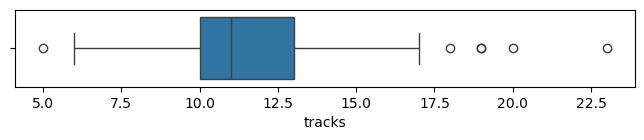

In [100]:
plt.figure(figsize=(8,1))
sns.boxplot(x=df_lengths_missing['tracks'])

In [101]:
df_lengths_missing.sort_values('album_length', ascending=False).head()

,artist,title,name,album_length,tracks
60,Virgin Steele,Age Of Consent,age of consent,115.13,23
32,Tori Amos,The Beekeeper,the beekeeper,79.25,19
84,Wo Fat,The Gathering Dark,the gathering dark,78.93,12
91,Yes,Symphonic Live,symphonic live,76.72,10
30,Tom Waits,Alice,alice (anniversary edition),75.61,20


<Axes: xlabel='album_length'>

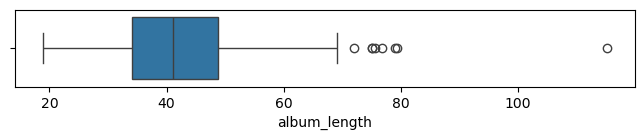

In [102]:
plt.figure(figsize=(8,1))
sns.boxplot(x=df_lengths_missing['album_length'])

In [103]:
df_lengths_missing.to_csv('Datasets/df_lengths_missing11.csv', index=False)

In [113]:
dfs = {}

for i in range(1,12):
    dfs[f"df_lengths_missing{i}"] = pd.read_csv(f'Datasets/df_lengths_missing{i}.csv')

In [116]:
for i in dfs:
    print(f"{dfs[i].shape}")

(11, 5)
(50, 5)
(56, 5)
(62, 5)
(59, 5)
(66, 5)
(63, 5)
(55, 5)
(58, 5)
(62, 5)
(94, 5)


In [121]:
df_lengths_missing_concat2 = pd.concat([dfs[df] for df in dfs])
df_lengths_missing_concat2.shape

(636, 5)

In [122]:
df_lengths_missing_concat2

,artist,title,name,album_length,tracks
0,108,A New Beat From A Dead Heart,a new beat from a dead heart,34.65,13
1,40 Below Summer,Rain,rain,49.32,12
2,A Great Big Pile of Leaves,Have You Seen My Prefrontal Cortex?,have you seen my prefrontal cortex?,49.64,13
3,A Pale Horse Named Death,And Hell Will Follow Me,and hell will follow me,53.77,13
4,A Place to Bury Strangers,Exploding Head,exploding head,43.13,10
...,...,...,...,...,...
89,Xiu Xiu,The Air Force,the air force,34.71,11
90,Yeasayer,Odd Blood,odd blood,39.63,10
91,Yes,Symphonic Live,symphonic live,76.72,10
92,Yesterdays Rising,Lightworker,lightworker,49.72,12


In [123]:
df_lengths_missing_concat1 = pd.read_csv('Datasets/df_lengths_missing_concat1.csv')
df_lengths_missing_concat1.shape

(1922, 5)

In [124]:
df_lengths_missing_concat2.to_csv('Datasets/df_lengths_missing_concat2.csv', index=False)

In [125]:
df_lengths_missing_concat = pd.concat([df_lengths_missing_concat1, df_lengths_missing_concat2])
df_lengths_missing_concat.shape

(2558, 5)

In [152]:
df_lengths_missing_concat = df_lengths_missing_concat.sort_values(['artist', 'title'])
df_lengths_missing_concat.reset_index(drop=True, inplace=True)
df_lengths_missing_concat.head()

,artist,title,name,album_length,tracks
0,...And You Will Know Us by the Trail of Dead,Madonna,madonna,45.57,13
1,108,A New Beat From A Dead Heart,a new beat from a dead heart,34.65,13
2,108,Songs of Separation,songs of separation,32.85,14
3,10cc,10cc,10cc,35.23,10
4,10cc,Deceptive Bends,deceptive bends,51.21,12


In [151]:
df_lengths_missing_concat.to_csv('Datasets/df_lengths_missing_concat.csv', index=False)

<Axes: xlabel='tracks'>

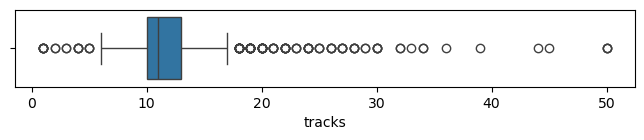

In [318]:
plt.figure(figsize=(8,1))
sns.boxplot(x=df_lengths_missing_concat['tracks'])

<Axes: xlabel='album_length'>

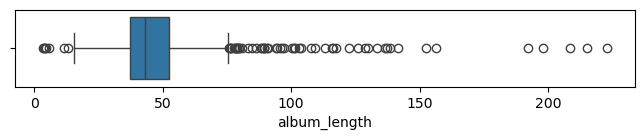

In [319]:
plt.figure(figsize=(8,1))
sns.boxplot(x=df_lengths_missing_concat['album_length'])

In [11]:
df_length_0['artist'].value_counts().head(10)

artist
The Fall              10
The Kinks             10
Hawkwind              10
Pink Floyd             9
The Mountain Goats     9
Genesis                9
Elton John             9
The Who                8
The Beatles            8
Black Sabbath          8
Name: count, dtype: int64

In [12]:
df_length_0.shape

(2234, 13)

In [13]:
df_length_0['artist'].nunique()

1442